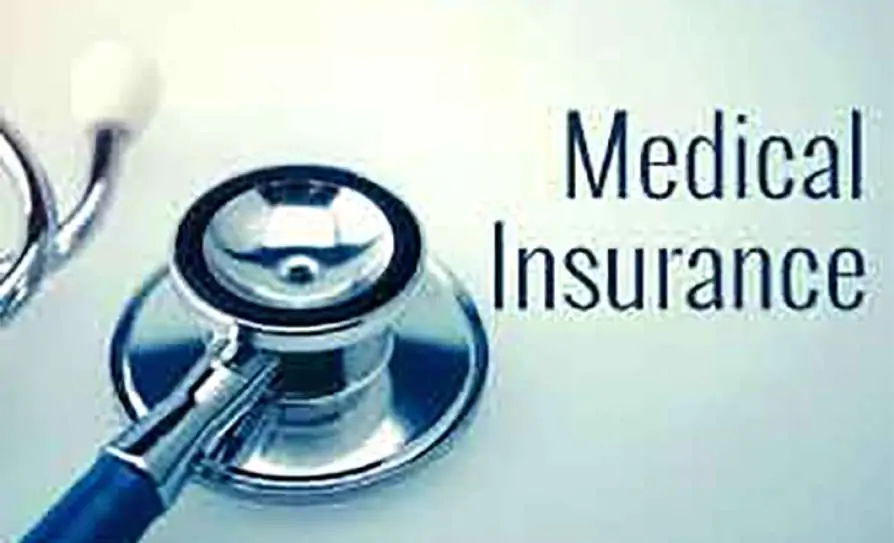]

#     Import the necessary libraries

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split,GridSearchCV,cross_val_score
from sklearn.metrics import r2_score,roc_auc_score,roc_curve,mean_absolute_error,mean_squared_error 
from sklearn.preprocessing import MinMaxScaler,LabelEncoder
from sklearn.feature_selection import RFE

import warnings
warnings.filterwarnings('ignore')

#     Import the dataset

In [ ]:
df = pd.read_csv('../input/insurance.csv')
df.head()

    Understanding the data - 
    
    Age: age of beneficiary, years

    Sex: gender of beneficiary, [female, male]

    BMI: Body mass index, providing an understanding of body, weights that are relatively high or low relative to height,
    objective index of body weight (kg / m ^ 2) using the ratio of height to weight, ideally 18.5 to 24.9

    Children: number of dependents covered by health insurance (will change the children to dependents in the code

    Smoker: smoking, [yes, no]

    Region: the beneficiary’s residential area in the US, [northeast, southeast, southwest, northwest]

    Charges: Individual medical costs billed by medical insurance, $ #predicted value

#     Data Preprocessing

In [ ]:
len(df[df['charges'] > 50000])

In [ ]:
df = df[df['charges'] < 50000]

    Grouping the age in 3 groups.
    Let's change the 'children' column to 'dependents' for better understanding
    Dropping the columns not needed anymore

In [ ]:
df['Age'] = pd.cut(df.age,bins=[18,30,50,65],labels=['18-30','30-50','50-65'],include_lowest=True)

df.rename(columns = {'children':'dependents'},inplace=True)

#     Exploratory Data Analysis

In [ ]:
fig = plt.figure(figsize=(15,10))
fig.suptitle('Medical Charges Plot', fontsize=10,fontweight="bold", color="black", 
             position=(0.5,1.01))

ax1 = fig.add_subplot(231)
ax1.scatter(df['age'], df['charges'], c="green")
ax1.set_title('age Vs charges',  color="green")
ax1.set_ylabel("charges")
ax1.set_xlabel("age");

ax2 = fig.add_subplot(232)
ax2.scatter(df['bmi'], df['charges'], c="orange")
ax2.set_title('bmi vs charges', color="orange")
ax2.set_ylabel("charges")
ax2.set_xlabel("bmi");

ax3 = fig.add_subplot(233)
ax3.scatter(df['sex'], df['charges'], c="red")
ax3.set_title('sex vs charges', color="red")
ax3.set_ylabel("charges")
ax3.set_xlabel("sex");

ax4 = fig.add_subplot(234)
ax4.scatter(df['dependents'], df['charges'], c="blue")
ax4.set_title('dependents vs charges', color="blue")
ax4.set_ylabel("charges")
ax4.set_xlabel("dependents");

ax5 = fig.add_subplot(235)
ax5.scatter(df['smoker'], df['charges'], c="gray")
ax5.set_title('smoker vs charges', color="gray")
ax5.set_ylabel("charges")
ax5.set_xlabel("smoker");

ax6 = fig.add_subplot(236)
ax6.scatter(df['region'], df['charges'], c="gray")
ax6.set_title('region vs charges', color="gray")
ax6.set_ylabel("charges")
ax6.set_xlabel("region");

plt.show();

In [ ]:
plt.figure(figsize=(10,5));


fig, (ax1, ax2) = plt.subplots(1,2, figsize = (20, 6));
fig.suptitle('Smoker  Vs (Age and Sex)', fontsize=10,fontweight="bold", color="black", 
             position=(0.5,1.01));

sns.countplot(x=df['smoker'],hue=df['Age'],palette='muted',ax=ax1);
ax1.set_title('age vs smoker');
ax1.set_ylabel("smoker");
ax1.set_xlabel("Age");

sns.countplot(x=df['smoker'],hue=df['sex'],palette='muted',ax=ax2);
ax2.set_title('smoker vs sex');
ax2.set_ylabel("smoker");
ax2.set_xlabel("sex");

plt.show()

#     Convert/encode the values into numeric.

In [ ]:
le = LabelEncoder()

df['sex'] = le.fit_transform(df['sex'])
df['smoker'] = le.fit_transform(df['smoker'])
df['Age'] = le.fit_transform(df['Age'])
df['region'] = le.fit_transform(df['region'])

#     Scale the numerical values of bmi

In [ ]:
mms = MinMaxScaler()

df['bmi'] = mms.fit_transform(df[['bmi']].values)

#     Seperate the features and target into X and y (dropping all the columns we don't need). Also split the data into train and test.**

In [ ]:
X = df.drop(['charges','age'],axis=1)
y = df['charges']
train,test,train_labels,test_labels = train_test_split(X,y,test_size=0.3)

#     RandomForest Regressor
        #  This is the algorithm used here to predict the unknown charges. Grid search is used to tune hyperparameters which will evaluate different combinations of hyperparameters 
           using cross-validation. The utility function is neg_mean_squared_error.

In [ ]:

grid = GridSearchCV(estimator=RandomForestRegressor(),param_grid={'max_depth': range(3,7),'n_estimators': (10, 50, 100, 1000),},
                    cv=5,scoring='neg_mean_squared_error',verbose=0,n_jobs=-1)#
    
grid.fit(train,train_labels)

best_params = grid.best_params_
best_params

In [ ]:

for mean_score, params in zip(grid.cv_results_["mean_test_score"], grid.cv_results_["params"]):
  # neg_mean_squared_error was used hence add minus before mean_score.
  print(np.sqrt(-mean_score), params)

#     Fit and predict the reggressor with best selected parameters

In [ ]:
rfr = RandomForestRegressor(max_depth=best_params["max_depth"], n_estimators=best_params["n_estimators"],
                            random_state=False, verbose=False)

rfr.fit(train,train_labels)

test_pred = rfr.predict(test)


print('Mean Absolute Error:',mean_absolute_error(test_labels, test_pred))
print('Mean Squared Error:', mean_squared_error(test_labels,test_pred))
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(test_labels,test_pred)))

#     K-Fold Validation

In [ ]:
scores = cross_val_score(rfr, train, train_labels, cv=10, scoring='neg_mean_squared_error')

rfr_rmse_scores  = np.sqrt(-scores)
rfr_rmse_scores

#     Finally, the r2-score

In [ ]:

print(r2_score(test_labels, test_pred))